In [485]:
import sys
sys.path.append('../')
import datetime
import pandas as pd
import numpy as np
from lib import get_data
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import backend

from tensorflow.keras import Model, Sequential
from tensorflow.keras.models import model_from_json
from tensorflow.keras.layers import Input, SimpleRNN, Dense, GRU, Dropout, Bidirectional,\
                                    BatchNormalization, LSTM, LeakyReLU, Concatenate, GaussianNoise
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from sklearn.model_selection import train_test_split

print(tf.keras.__version__)
print(tf.__version__)

2.2.4-tf
2.1.0


In [150]:
OTHERS = ['date', 'county', 'state', 'fips', 'cases', 'deaths', 
                'income_2018', 'pop_2018', 'pred_days_since_10_cases',
                'pred_cases', 'pred_deaths']
WEATHER = ['heatIndexMin', 'heatIndexAvg', 'heatIndexMax','relHumMin',
                'relHumAvg', 'relHumMax',  'tempMin', 'tempAvg', 'tempMax', 'windChillMin', 'windChillAvg',
                'windChillMax', 'windDirAvg']
MOBILITY = ['retail_and_recreation_percent_change_from_baseline',
                'residential_percent_change_from_baseline',
                'workplaces_percent_change_from_baseline',
                'transit_stations_percent_change_from_baseline',
                'grocery_and_pharmacy_percent_change_from_baseline',
                'parks_percent_change_from_baseline']
COLUMNS = OTHERS + WEATHER + MOBILITY
LEN = 6

In [14]:
processed_path = '../data/processed/time_series_updated.csv'
data = pd.read_csv(processed_path)

In [15]:
# normalize 
income_max = data['income_2018'].max()
income_min = data['income_2018'].min()
data['income_2018'] = (data['income_2018'] - income_min) / income_max

pop_max = data['pop_2018'].max()
pop_min = data['pop_2018'].min()
data['pop_2018'] = (data['pop_2018']-pop_min)/pop_max

# # normalize weather
# weather = data[WEATHER]
# weather_max = weather.max()
# weather_min = weather.min()
# weather_new = (weather - weather_min)/weather_max
# data[WEATHER] = weather_new

# # nomalize mobility
# mobility = data[MOBILITY]
# mobility_mean = mobility.mean()
# mobility_std = mobility.std()
# mobility_new = (mobility - mobility_mean)/mobility_std
# data[MOBILITY] = mobility_new

In [151]:
def get_model_data_cumulative(data, date_range=(0, 14), pred_day=21):
    """

    :param date_range: integer measuring the number of days since first day w/ 10 cases
    :param pred_day:
    :return:
    """

    # ensure full coverage of interested dates
    data = data[data['fips'].isin(data[data['days_since_10_cases'] == pred_day]['fips'].drop_duplicates())]

    # filter for training and testing dates
    data_x = data[data['days_since_10_cases'].between(date_range[0], date_range[1])]
    data_grouped = data_x.groupby(['state', 'county', 'fips']).agg('mean').reset_index()  # todo play with granularity
    data_x = data_x.drop(['days_since_10_cases'], axis=1)

    # get change rate since last training date
    data_y = data[data['days_since_10_cases'].isin([date_range[1], pred_day])][
        ['fips', 'cases', 'deaths', 'days_since_10_cases']]
    data_y = data_y.sort_values(['fips', 'days_since_10_cases']).reset_index(drop=True)
    day_idx = np.where(data_y['days_since_10_cases'] == pred_day)[0]
    data_y_new = data_y.iloc[day_idx, :].reset_index()
    data_y_new = data_y_new.drop(['index'], axis=1)
    data_y_new['fips'] = data_y.loc[day_idx, 'fips'].reset_index(drop=True)
    data_y_new = data_y_new.add_prefix('pred_')
    
    
    data = data_x.merge(data_y_new, left_on='fips', right_on='pred_fips', how='inner')
#     data_grouped = data_grouped.merge(data_y, left_on='fips', right_on=f'day_{pred_day}_cumulative_fips',
#                                       how='inner')
#     data_grouped = data_grouped.drop(f'day_{pred_day}_cumulative_fips', axis=1)
    data = data.drop('pred_fips', axis=1)
    
    data = data[COLUMNS]
    data = data.fillna(0)
    data = data.drop(['county','state'],axis=1)
#     data_grouped = data_grouped[COLUMNS]
    return data 


Generating training set
-----------

In [550]:


def genrate_rnn_data(start, end, LEN, data):

    for i in range(start, end):
        df = get_model_data_cumulative(data, date_range=(i, i+LEN), pred_day=i+LEN+1)
        if df.empty is False:
            grouped_by_fips = df.groupby(['fips']).groups
            count = 0
            for fips in grouped_by_fips:
                index = grouped_by_fips[fips]
                y = np.expand_dims(df.iloc[index]['pred_cases'].to_numpy(),axis=0)
                features = df.iloc[index].drop(['pop_2018','income_2018','pred_cases','pred_deaths'],axis=1)
    #             train = np.expand_dims(df.iloc[index][['cases']].to_numpy(),axi,s=0)
    #             train = np.expand_dims(df.iloc[index].drop(['date','fips'],axis=1)[['cases','pred_cases']].to_numpy(),axis=0)
                statis_features = df.iloc[index][['pop_2018','income_2018']]

                if i == 1:
                    X_time_series = np.expand_dims(features.to_numpy(),axis=0)
                    time_series_col = features.columns
                    X_static = np.expand_dims(statis_features.iloc[0].to_numpy(),axis=0)
                    static_series_col = statis_features.columns
    #                 X_train = train[:,:,0]
                    y_true = y.mean()
    #                 y_train = train[:,:,1].mean()
                else:
                    X_time_series = np.vstack((X_time_series,  np.expand_dims(features.to_numpy(),axis=0)))
                    X_static = np.vstack((X_static,  np.expand_dims(statis_features.iloc[0].to_numpy(),axis=0)))
                    y_true =np.vstack((y_true, y.mean()))
    return X_time_series, X_static, y_true, time_series_col, static_series_col


In [551]:
start = 1
end = 100
X_time_series, X_static, y_true, time_series_col, static_series_col = genrate_rnn_data(start, end, LEN, data)

In [257]:
display(time_series_col.shape)
display(static_series_col)

(24,)

Index(['pop_2018', 'income_2018'], dtype='object')

In [ ]:
# np.save('../data/rnn_data/X_time_series.npy',X_time_series,allow_pickle)
# np.save('../data/rnn_data/X_static.npy',X_static)
# np.save('../data/rnn_data/y_true.npy',y_true)

### Split train_test

In [836]:
X_time_series = np.load('../data/rnn_data/X_time_series.npy',allow_pickle=True)
X_static = np.load('../data/rnn_data/X_static.npy',allow_pickle=True)
y_true = np.load('../data/rnn_data/y_true.npy',allow_pickle=True)

In [837]:
X_time_series_data = X_time_series[:,:,2:].astype(np.float32)
fips_date = X_time_series[:,:,:2]

X_time_series_train, X_time_series_test, X_static_train, \
    X_static_test, y_train, y_test, fips_date_train, fips_date_test = train_test_split(X_time_series_data, X_static, y_true, fips_date, test_size=0.1, random_state=109)


### Upsampling

In [838]:
def upsampling(x1, x2, y, threshold1,threshold2, rate):
    idx = np.where((y > threshold1) & (y < threshold2))[0]
    print(idx.shape)
    y_resample = np.tile(y[idx], (rate,1))
    noise = np.random.normal(0,10,y_resample.shape) 
    y_new = np.append(y,y_resample+noise,axis=0)
    
    
    X_time_series_resample = np.tile(x1[idx],(rate,1,1))
    x1_new = np.append(x1, X_time_series_resample,axis=0)

    X_static_resample = np.tile(x2[idx],(rate,1))
    x2_new = np.append(x2, X_static_resample,axis=0)
    
    return x1_new, x2_new, y_new

In [839]:
X_time_series_train, X_static_train, y_train = upsampling(X_time_series_train, X_static_train, y_train, 5000, 10000, 50)
X_time_series_train, X_static_train, y_train = upsampling(X_time_series_train, X_static_train, y_train, 10000, 20000, 500)
X_time_series_train, X_static_train, y_train = upsampling(X_time_series_train, X_static_train, y_train, 20000, 30000, 500)
X_time_series_train, X_static_train, y_train = upsampling(X_time_series_train, X_static_train, y_train, 30000, 40000, 1000)

(209,)
(73,)
(27,)
(2,)


In [840]:
X_time_series_train.shape

(79831, 7, 22)

RNN
--------

In [841]:
# your code here

# time series input
time_series_input = Input(shape=(7,22), name='time_series_input')
noise_layer1 = GaussianNoise(0.1)(time_series_input)
rnn1 = LSTM(64, return_sequences=True, recurrent_dropout=0.2)(noise_layer1)
rnn2 = LSTM(32)(rnn1)

#static input branch
static_input_layer = Input(shape=(2))
noise_layer2 = GaussianNoise(0.1)(static_input_layer)
static_dense = Dense(64)(noise_layer2)
static_dropout = Dropout(0.3)(static_dense)

concat = Concatenate(axis=-1)([rnn2,static_dropout])
dense = Dense(32)(concat)
dropout = Dropout(0.3)(dense)
output = Dense(1, activation='relu',name="output")(dropout)


model = Model([time_series_input,static_input_layer ], output, name='rnn')

model.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredLogarithmicError())

In [842]:
model.summary()

Model: "rnn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
time_series_input (InputLayer)  [(None, 7, 22)]      0                                            
__________________________________________________________________________________________________
input_32 (InputLayer)           [(None, 2)]          0                                            
__________________________________________________________________________________________________
gaussian_noise_11 (GaussianNois (None, 7, 22)        0           time_series_input[0][0]          
__________________________________________________________________________________________________
gaussian_noise_12 (GaussianNois (None, 2)            0           input_32[0][0]                   
________________________________________________________________________________________________

In [843]:
callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=4, verbose=1, factor=0.6),
             EarlyStopping(monitor='val_loss', patience=20),
             ModelCheckpoint(filepath='../../models/best_model_1.h5', monitor='val_loss', save_best_only=True)]

In [844]:
history = model.fit([X_time_series_train, X_static_train], y_train, batch_size=1024, epochs=200, 
                    validation_split=0.1, verbose=1, shuffle=True,  callbacks=callbacks)

Train on 71847 samples, validate on 7984 samples
Epoch 1/200
71847/71847 [==============================] - 5s 72us/sample - loss: 48.1881 - val_loss: 53.2583
Epoch 2/200
71847/71847 [==============================] - 2s 31us/sample - loss: 30.0136 - val_loss: 41.9421
Epoch 3/200
71847/71847 [==============================] - 2s 31us/sample - loss: 23.9690 - val_loss: 35.5592
Epoch 4/200
71847/71847 [==============================] - 2s 31us/sample - loss: 20.2069 - val_loss: 31.0086
Epoch 5/200
71847/71847 [==============================] - 2s 31us/sample - loss: 17.3528 - val_loss: 27.4297
Epoch 6/200
71847/71847 [==============================] - 2s 31us/sample - loss: 15.1811 - val_loss: 24.5286
Epoch 7/200
71847/71847 [==============================] - 2s 31us/sample - loss: 13.4114 - val_loss: 22.1275
Epoch 8/200
71847/71847 [==============================] - 2s 31us/sample - loss: 11.9663 - val_loss: 20.1021
Epoch 9/200
71847/71847 [==============================] - 2s 31us/samp

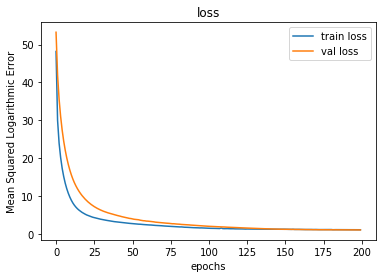

In [849]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'],label='val loss')
plt.legend()
plt.title('loss')
plt.xlabel('epochs')
plt.ylabel('Mean Squared Logarithmic Error');

In [845]:
pred = model.predict([X_time_series_test, X_static_test])
model.evaluate([X_time_series_test, X_static_test], y_test)

1932/1932 [==============================] - 0s 51us/sample - loss: 2.7274


2.727390992715492

### Case studies

In [730]:
def predict_cases(fips, model, data):
    index = (data['fips'] == fips)
    county = data.iloc[np.where(index)[0][0]]['county']
    state = data.iloc[np.where(index)[0][0]]['state']
    
    county_data = data[(data['fips'] == fips)]
    county_X_time_series_raw, county_X_static, county_y_true, county_time_series_col, county_static_series_col  = genrate_rnn_data(start, end, LEN, county_data)
    county_X_time_series = county_X_time_series_raw[:,:,2:].astype(np.float32)
    date = np.array([pd.to_datetime(row[0][0]) for row in county_X_time_series_raw])
    index = sorted(range(len(date)), key=lambda k: date[k])
    
    date_new = date[index]
    county_X_time_series = county_X_time_series[index]
    county_X_static = county_X_static[index]
    county_y_true = county_y_true[index]
    
    predict_test = model.predict([county_X_time_series, county_X_static])
    plt.scatter(range(len(date_new)), predict_test, label='predicted cases')
    plt.scatter(range(len(date_new)),county_y_true, label='true cases')
    plt.xlabel('day since first 10 cases')
    plt.ylabel('cases')
    plt.legend()
    plt.title('Cases for {}, {}'.format(county, state))

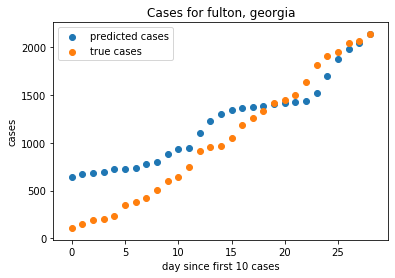

In [866]:
predict_cases(13121, model, data)

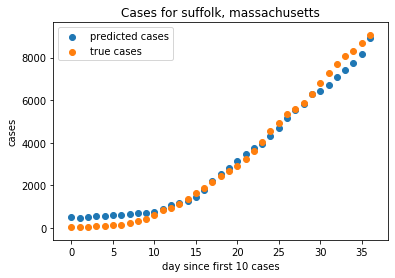

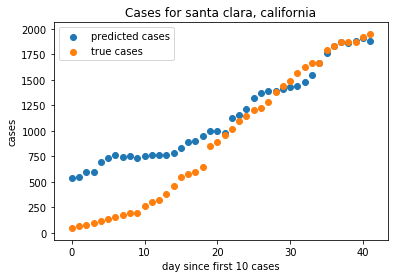

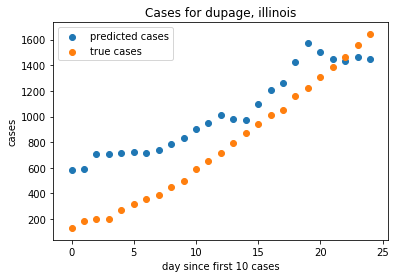

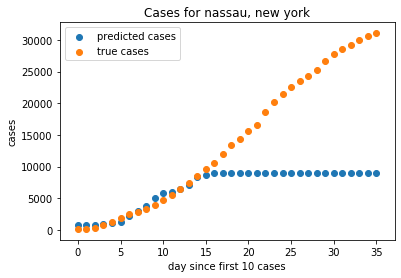

In [862]:
predict_cases(25025, model, data)
plt.show()
predict_cases(6085, model, data)
plt.show()
predict_cases(17043, model, data)
plt.show()
predict_cases(6037, model, data)
plt.show()
predict_cases(36059, model, data)

